# Wine RECOMEND. DATA ANALYSIS
## Часть 1. Совмещение файлов в одну базу данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
colors = ['#31456a', '#59729a', '#a06d7c', '#f0bfb0', '#fae3b9']

c:\Users\lera-\.virtualenvs\-SNfpu_4o\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Чтение всех баз данных
simplewine_df = pd.read_excel('simplewine_rev.xlsx')
decanter_df = pd.read_excel('wine_decanter_rev.xlsx')
kaggle_df150 = pd.read_csv('winemag-data_first150k.csv')
kaggle_df130 = pd.read_csv('winemag-data-130k-v2.csv')

### 1.1. Базы данных Kaggle
#### 1.1.1. Совмещение БД и удаление полностью дуюлирующихся строк
На данном этапе проводим совмещение двух баз данных из Kaggle, они частично повторяют друг друга, поэтому удалим дублирующиеся строки

In [3]:
# Совмещение двух баз из kaggle
result_df = pd.concat([kaggle_df150, kaggle_df130], ignore_index=True)
result_df = result_df.drop(columns=['Unnamed: 0']) #Удаление лишней колонки
# Удаление полных дубликатов 280901 - 217839
result_df = result_df.drop_duplicates()
result_df

,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280896,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...
280897,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Pinot Noir,Citation,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon)
280898,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Gewürztraminer,Domaine Gresser,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...
280899,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Pinot Gris,Domaine Marcel Deiss,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace)


#### 1.2. Структура БД
Полные дубликаты были удалены, разберемся с основной **структурой базы данных**, чтобы понять как ее совместить с русскими базами:
- country - Страна 
- description - Отзыв
- designation - Бренд 
- points - Оценка по стобальной шкале
- price - Цена
- province - Крупный регион
- region_1 - Мелкий регион 1
- region_2 - Мелкий регион 2
- variety - Сорт винограда
- winery - Винодельня
- taster_name - Имя рецензента
- taster_twitter_handle - Твиттер рецензента
- title - Название вина

В этих базах данных не хватает многой важной информации, например о сладости/сухости, крепости - чтобы дополнить это, сформируем отдельную базу данных по всем винам. Есть большое количество пропущенных значений в таких важных столбцах, как название вина, Бренд, которые могут не позволить использовать эти значения для разработки рекомендательной системы.

In [4]:
result_df.info() # Информация по датасету

<class 'pandas.core.frame.DataFrame'>
Index: 217839 entries, 0 to 280900
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                217777 non-null  object 
 1   description            217839 non-null  object 
 2   designation            153398 non-null  object 
 3   points                 217839 non-null  int64  
 4   price                  200724 non-null  float64
 5   province               217777 non-null  object 
 6   region_1               182347 non-null  object 
 7   region_2               86260 non-null   object 
 8   variety                217838 non-null  object 
 9   winery                 217839 non-null  object 
 10  taster_name            95071 non-null   object 
 11  taster_twitter_handle  90542 non-null   object 
 12  title                  119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 23.3+ MB


Удалим из базы данных все строки, в которых не написаны названия вина и бренд, так как эти данные мы не сможем использовать для рекомендательной системы

In [5]:
result_df = result_df.dropna(subset = ['title']) #Удаление пустых строк

#### 1.1.4. Удаление года из названия
Так как наша рекомендательная система будет работатб на виды вида, а не на определнные года, то уберем из всех названий год

In [6]:
def remove_year_from_wine_name(wine_name):
    # Регулярное выражение для поиска года в строке
    year_pattern = re.compile(r'\b\d{4}\b')

    # Заменяем найденные года на пустую строку
    wine_name_without_year = re.sub(year_pattern, '', wine_name)

    return wine_name_without_year.strip()  # Убираем лишние пробелы, если они есть

result_df['title'] = result_df['title'].apply(remove_year_from_wine_name)

C:\Users\lera-\AppData\Local\Temp\ipykernel_7132\358019290.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['title'] = result_df['title'].apply(remove_year_from_wine_name)


#### 1.1.3. Группировка отзывов
Для многих вин написано несколько отзывов, чтобы получить всю информацию о них сгруппируем отзывы

In [7]:
# Группировка по названию вина
result_df = result_df.groupby('title').agg({'country' : 'first', 'designation': 'first', 
                       'points': 'first', 'province': 'first', 'region_1': 'first', 
                       'region_2': 'first', 'variety': 'first', 'winery' : 'first', 'description': 'sum'})
result_df = result_df.reset_index() # Сброс индексов
result_df

,title,country,designation,points,province,region_1,region_2,variety,winery,description
0,1+1=3 Rosé Cabernet Sauvignon (Penedès),Spain,Rosé,82,Catalonia,Penedès,None,Cabernet Sauvignon,1+1=3,The previous two years we did not find this wi...
1,1+1=3 NV Brut Sparkling (Cava),Spain,Brut,87,Catalonia,Cava,None,Sparkling Blend,1+1=3,Spiced apple and toast aromas are clean and di...
2,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Spain,Cygnus Brut Nature Reserva Made With Organic G...,89,Catalonia,Cava,None,Sparkling Blend,1+1=3,"Clean, fresh apple aromas and a minerally, cit..."
3,1+1=3 NV Rosé Sparkling (Cava),Spain,Rosé,86,Catalonia,Cava,None,Sparkling Blend,1+1=3,"A dusty, yeasty nose is simplistic but friendl..."
4,10 Knots Beachcomber White (Paso Robles),US,Beachcomber,83,California,Paso Robles,Central Coast,Rhône-style White Blend,10 Knots,"A Rhône blend of Viognier, Roussanne and Marsa..."
...,...,...,...,...,...,...,...,...,...,...
81726,àMaurice Viognier (Columbia Valley (WA)),US,None,92,Washington,Columbia Valley (WA),Columbia Valley,Viognier,àMaurice,"Always a strong suit from àMaurice, the 2009 V..."
81727,àMaurice William Ivey Red (Columbia Valley (WA)),US,William Ivey,91,Washington,Columbia Valley (WA),Columbia Valley,Bordeaux-style Red Blend,àMaurice,"This wine is half Cabernet Sauvignon, with the..."
81728,àMaurice NV Pour Me Red (Columbia Valley (WA)),US,Pour Me,89,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,àMaurice,Pour Me is a new label produced by the talente...
81729,Štoka Grganja Vitovska (Kras),Slovenia,Grganja,90,Kras,None,None,Vitovska,Štoka,This orange-style wine is dark straw in color ...


In [8]:
result_df.to_excel('Kaggle_sum.xlsx')

### 1.2. Русские базы данных
Сначала уберем из каждой базы данных лишние колонки, это повторы колонок, колонки, не несущие информации, такие как артикул

In [9]:
# Удаление лишних колонок
simplewine_df = simplewine_df.drop(columns=['Крепость'])
decanter_df = decanter_df.drop(columns=['Артикул', 'Подробнее'])

# Переименование колонок
simplewine_df.rename(columns={'Страна, регион': 'Страна', 'Крепость.1': 'Крепость'}, inplace=True)
decanter_df.rename(columns={'Объем (л)': 'Объем'}, inplace=True )

#### 1.2.1. Simplewine
Поработаем с базой данных Simplewine, чтобы привести все форматы данных в нормальный вид.

In [10]:
simplewine_df.info() # Информация по базе данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9026 entries, 0 to 9025
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Название            9026 non-null   object 
 1   Страна              9026 non-null   object 
 2   Сахар               8821 non-null   object 
 3   Виноград            9026 non-null   object 
 4   Производитель       9026 non-null   object 
 5   Объем               9026 non-null   object 
 6   Регион              8781 non-null   object 
 7   Крепость            9015 non-null   object 
 8   Аппелласьон         8267 non-null   object 
 9   Декантация          8006 non-null   object 
 10  Год                 8441 non-null   float64
 11  Потенциал хранения  8724 non-null   object 
 12  Категория           8125 non-null   object 
 13  Выдержка в емкости  8853 non-null   object 
 14  Сладость            7782 non-null   float64
 15  Кислотность         7782 non-null   float64
 16  Танины

Основные проблемы базы данных:
- Слово Вино в названии
- Объем, Крепость должны быть типа float
- В описании много символов \n
- Также есть большое количество пропущенных колонок

In [11]:
# Удаление слово Вино
def remove_wine(original_name):
    new_name = re.sub(r'\b' + re.escape('Вино ') + r'\b', '', original_name)
    new_name = re.sub(r'\b' + re.escape('безалкогольное ') + r'\b', '', new_name)
    return new_name

simplewine_df['Название'] = simplewine_df['Название'].apply(remove_wine)

In [12]:
# Заполнение прорущенных значений крепости вина
simplewine_df['Крепость'][simplewine_df['Название'] == 'Domaine de la Prade Rouge, 0,0%, Oddbird'] = '0%'
simplewine_df['Крепость'][simplewine_df['Название'] == "Le Grand Noir Winemaker’s Selection Chardonnay, Les Celliers Jean d'Alibert"] = '13.5%'

C:\Users\lera-\AppData\Local\Temp\ipykernel_7132\3625515777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplewine_df['Крепость'][simplewine_df['Название'] == 'Domaine de la Prade Rouge, 0,0%, Oddbird'] = '0%'
C:\Users\lera-\AppData\Local\Temp\ipykernel_7132\3625515777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplewine_df['Крепость'][simplewine_df['Название'] == "Le Grand Noir Winemaker’s Selection Chardonnay, Les Celliers Jean d'Alibert"] = '13.5%'


In [13]:
# Удаление л. из объема
simplewine_df['Объем'] = simplewine_df['Объем'].apply(lambda x: float(re.sub(r'\b' + re.escape(' л') + r'\b', '', x)))

# Удаление % из Крепости
simplewine_df['Крепость'] = simplewine_df['Крепость'].apply(lambda x: float(re.sub(re.escape('%'), '', x)))

In [14]:
# Удаление лишних символов \n из описания
simplewine_df['Описание'] = simplewine_df['Описание'].apply(lambda x: re.sub(re.escape('\n'), '', x) if isinstance(x, str) else x)

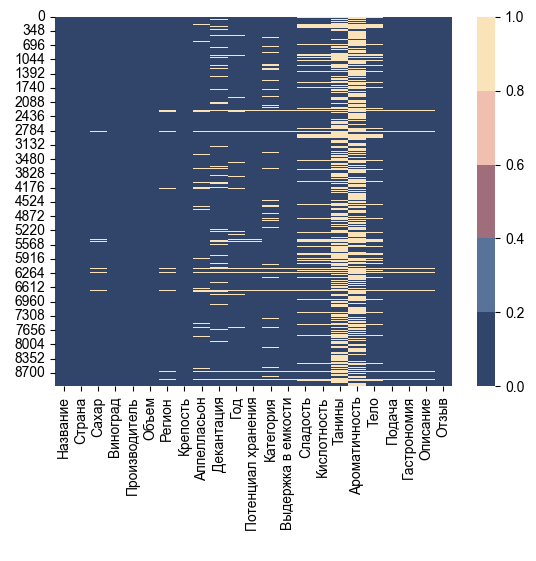

In [15]:
# Пропущенные значения в колонках
#поиск пустых ячеек, она некорректно отображается, если нет пустых ячеек
cols = simplewine_df.columns
# желтый - пропущенные данные, синий - не пропущенные
sns.heatmap(simplewine_df[cols].isnull(), cmap=sns.color_palette(colors))
sns.set (font_scale=0.5)

Большинство пропусков в столбцах танины и ароматичность, но есть все названия и отзывы, поэтому можно работать с этой базой

#### 1.2.2. Decanter
Исправим основные проблемы этой базы данных

In [16]:
decanter_df.info() # Информация по базе данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Название            3153 non-null   object
 1   Крепость            3152 non-null   object
 2   Объем               3154 non-null   object
 3   Цвет                3154 non-null   object
 4   Сахар               3154 non-null   object
 5   Бренд               3154 non-null   object
 6   Страна              3154 non-null   object
 7   Регион              2934 non-null   object
 8   Субрегион           1360 non-null   object
 9   Выдержка в ёмкости  1811 non-null   object
 10  Виноград            3085 non-null   object
 11  Температура подачи  3086 non-null   object
 12  Потенциал хранения  2809 non-null   object
 13  Стиль вина          2115 non-null   object
 14  Гастрономия         2653 non-null   object
 15  Описание            3114 non-null   object
 16  Винтаж              2179

In [17]:
# Удалим строку, в которых нет названий
index_nan = decanter_df[decanter_df['Название'].isna()].index
decanter_df = decanter_df.drop(index=index_nan)

# Удалим набор вин
index_krep = decanter_df[decanter_df['Крепость'].isna()].index
decanter_df = decanter_df.drop(index=index_krep)

**Основные проблемы:**
- В названии указан объем, который не нужен и мешает
- Крепость, Объем должны быть формата float

In [18]:
# Уберем объем из названия, который записан через запятую
decanter_df['Название'] = decanter_df['Название'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)

# Исправление ошибок в столбце Объем
decanter_df['Объем'][(decanter_df['Объем'] == 'Выдержка') | (decanter_df['Объем'] == 'Цвет')] = 0.75

# Конвертация объема во float
decanter_df['Объем'] = decanter_df['Объем'].apply(lambda x: float(x))

# Удаление % из Крепости
decanter_df['Крепость'] = decanter_df['Крепость'].apply(lambda x: float(re.sub(re.escape('%'), '', x) if isinstance(x, str) else x))

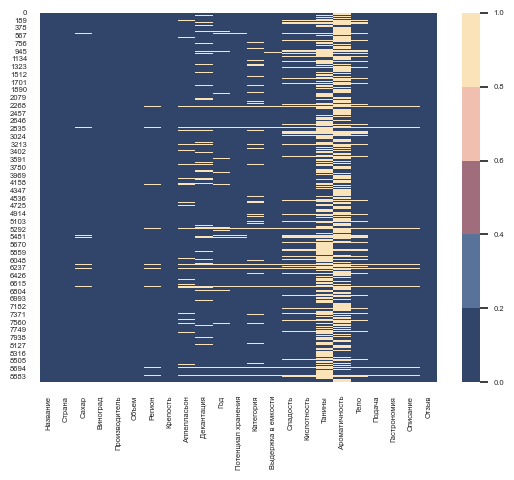

In [19]:
# Пропущенные значения в колонках
#поиск пустых ячеек, она некорректно отображается, если нет пустых ячеек
cols = simplewine_df.columns
# желтый - пропущенные данные, синий - не пропущенные
sns.heatmap(simplewine_df[cols].isnull(), cmap=sns.color_palette(colors))
sns.set (font_scale=0.5)

#### 1.2.3. Совмещение русских баз данных

In [20]:
# Совмещаем базы данных
result_df_rus = pd.concat([decanter_df, simplewine_df], ignore_index=True)
result_df_rus

,Название,Крепость,Объем,Цвет,Сахар,Бренд,Страна,Регион,Субрегион,Выдержка в ёмкости,...,Аппелласьон,Декантация,Год,Выдержка в емкости,Сладость,Кислотность,Танины,Ароматичность,Тело,Подача
0,Луис Фелипе Эдвардс Шардоне Пьюпилла,13.5,0.75,белое,сухое,Луис Фелипе Эдвардс,Чили,Регион Аконкагуа,Долина Лейда,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Луис Фелипе Эдвардс Шардоне Пьюпилла,13.5,0.75,белое,сухое,Луис Фелипе Эдвардс,Чили,Регион Аконкагуа,Долина Лейда,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Луис Фелипе Эдвардс Шардоне Пьюпилла,13.5,0.75,белое,сухое,Луис Фелипе Эдвардс,Чили,Регион Аконкагуа,Долина Лейда,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Луис Фелипе Эдвардс Шардоне Пьюпилла,13.5,0.75,белое,сухое,Луис Фелипе Эдвардс,Чили,Регион Аконкагуа,Долина Лейда,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Луис Фелипе Эдвардс Шардоне Пьюпилла,13.5,0.75,белое,сухое,Луис Фелипе Эдвардс,Чили,Регион Аконкагуа,Долина Лейда,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172,"Палава/Рислинг, Шумринка, 2020 г.,0.5 л.",10.1,0.50,NaN,сладкое,NaN,Россия,Кубань,NaN,NaN,...,ЗГУ Кубань. Анапа,не рекомендуется,2020.0,Нейтральная Емкость,NaN,NaN,NaN,NaN,NaN,8–10°С
12173,"Палава/Рислинг, Шумринка, 2020 г.,0.5 л.",10.1,0.50,NaN,сладкое,NaN,Россия,Кубань,NaN,NaN,...,ЗГУ Кубань. Анапа,не рекомендуется,2020.0,Нейтральная Емкость,NaN,NaN,NaN,NaN,NaN,8–10°С
12174,"Палава/Рислинг, Шумринка, 2020 г.,0.5 л.",10.1,0.50,NaN,сладкое,NaN,Россия,Кубань,NaN,NaN,...,ЗГУ Кубань. Анапа,не рекомендуется,2020.0,Нейтральная Емкость,NaN,NaN,NaN,NaN,NaN,8–10°С
12175,"Палава/Рислинг, Шумринка, 2020 г.,0.5 л.",10.1,0.50,NaN,сладкое,NaN,Россия,Кубань,NaN,NaN,...,ЗГУ Кубань. Анапа,не рекомендуется,2020.0,Нейтральная Емкость,NaN,NaN,NaN,NaN,NaN,8–10°С


#### 1.2.4. Группировка данных по одинаковым винам
Необходимо сгруппировать данные для одинаковых вин, чтобы получить наиболее полное представление о вине, также в столбец отзыв добавим описание вина и его гастрономические сочетания

In [21]:
#Удаление года
result_df_rus['Название'] = result_df_rus['Название'].apply(remove_year_from_wine_name)

In [22]:
# Группировка по названию
result_df_rus = result_df_rus.groupby('Название').agg({'Крепость': 'first', 'Цвет': 'first', 'Сахар': 'first', 'Страна': 'first',
                                                'Регион': 'first', 'Виноград': 'first', 'Гастрономия': 'first',
                                                'Описание': 'first', 'Отзыв': 'sum'})
result_df_rus = result_df_rus.reset_index()
result_df_rus

,Название,Крепость,Цвет,Сахар,Страна,Регион,Виноград,Гастрономия,Описание,Отзыв
0,19 Преступлений Бехайнд Барс Ред,13.5,красное,полусухое,Австралия,Виктория,Гренаш/гарнача,"Курица, Паста, Ризотто, Рыба",ОписаниеТерруар:Вино Prunotto Roero Arneis DOC...,"Вино приятное, не кислит и освежает легким пос..."
1,19 Преступлений Изгнанник,13.5,красное,полусухое,Австралия,Виктория,Гренаш/гарнача,"Говядина, Итальянская кухня, Стейк",None,"Это очень хорошее израильское вино, вкусное, н..."
2,19 Преступлений Снуп Догг Кали Ред,13.5,красное,полусладкое,США,Калифорния,Пти сира,None,None,"Вино отличное, очень мягко и легко пьется. Пос..."
3,19 Преступлений Совиньон Блок,12.0,белое,полусухое,Австралия,Южная Австралия,Совиньон блан,"Грибы, Курица, Паста, Свинина, Сыр мягкий, Утка",ОписаниеТерруар:Inkerman Pinot Noir — красное ...,Вино ужасное. С послевкусием горечи! Никак не ...
4,7 Element Cabernet Sauvignon,14.3,красное,сухое,Россия,Крым,Каберне совиньон,"Говядина, Итальянская кухня, Стейк",ОписаниеВыдержка вина:Непродолжительная выдерж...,"У вина приятный аромат фруктов, больше всего у..."
...,...,...,...,...,...,...,...,...,...,...
3021,Янардаг Белое Полусладкое,12.0,белое,полусладкое,Азербайджан,Галилея,Верментино,"Морепродукты, Паста, Ризотто, Рыба",ОписаниеТерруар:Вино Yanardag White Semi-Sweet...,Брал в подарок для коллеги на Новый год. Очень...
3022,Янардаг Белое Полусухое,12.0,белое,полусухое,Азербайджан,Южная Австралия,Верментино,"Морепродукты, Паста, Ризотто, Рыба",ОписаниеТерруар:Вино Yanardag White Semi-Dry и...,"Для меня, как для любителя сухих вин, Яламба З..."
3023,Янардаг Красное Полусухое,12.0,красное,полусухое,Азербайджан,None,Санджовезе,"Говядина, Мясо на гриле, Свинина, Стейк",ОписаниеТерруар:Вино Yanardag Red Semi-Dry изг...,"Если бы я не знала, что оно полусухое, подумал..."
3024,Янардаг Красное Сухое,13.0,красное,сухое,Азербайджан,None,Санджовезе,"Говядина, Мясо на гриле, Свинина, Стейк",ОписаниеТерруар:Вино Yanardag Red Dry изготовл...,"Обычное фруктовое вино, ничем особенным мне он..."


In [23]:
# Получим полный отзыв, добавив в него описание вина и гастронмические характеристики
result_df_rus['Отзыв'] = result_df_rus.apply(lambda row: ' '.join(filter(None, [row['Отзыв'], row['Описание'], row['Гастрономия']])), axis=1)
result_df_rus= result_df_rus.drop(columns=['Описание', 'Гастрономия'], axis = 1)
result_df_rus

,Название,Крепость,Цвет,Сахар,Страна,Регион,Виноград,Отзыв
0,19 Преступлений Бехайнд Барс Ред,13.5,красное,полусухое,Австралия,Виктория,Гренаш/гарнача,"Вино приятное, не кислит и освежает легким пос..."
1,19 Преступлений Изгнанник,13.5,красное,полусухое,Австралия,Виктория,Гренаш/гарнача,"Это очень хорошее израильское вино, вкусное, н..."
2,19 Преступлений Снуп Догг Кали Ред,13.5,красное,полусладкое,США,Калифорния,Пти сира,"Вино отличное, очень мягко и легко пьется. Пос..."
3,19 Преступлений Совиньон Блок,12.0,белое,полусухое,Австралия,Южная Австралия,Совиньон блан,Вино ужасное. С послевкусием горечи! Никак не ...
4,7 Element Cabernet Sauvignon,14.3,красное,сухое,Россия,Крым,Каберне совиньон,"У вина приятный аромат фруктов, больше всего у..."
...,...,...,...,...,...,...,...,...
3021,Янардаг Белое Полусладкое,12.0,белое,полусладкое,Азербайджан,Галилея,Верментино,Брал в подарок для коллеги на Новый год. Очень...
3022,Янардаг Белое Полусухое,12.0,белое,полусухое,Азербайджан,Южная Австралия,Верментино,"Для меня, как для любителя сухих вин, Яламба З..."
3023,Янардаг Красное Полусухое,12.0,красное,полусухое,Азербайджан,None,Санджовезе,"Если бы я не знала, что оно полусухое, подумал..."
3024,Янардаг Красное Сухое,13.0,красное,сухое,Азербайджан,None,Санджовезе,"Обычное фруктовое вино, ничем особенным мне он..."


#### 1.2.5. Перевод русской базы данных
Чтобы корректно совместить базы данных и делать дальше корректные предсказания, переведем русскую базу данных на английский язык

In [25]:
from googletrans import Translator
import googletrans

def translate_to_english(text):
    translator = Translator()
    translation = translator.translate(text, dest='en')
    return translation.text


for col in ['Название', 'Цвет', 'Сахар', 'Страна', 'Регион', 'Виноград', 'Отзыв']:
    print(col)
    result_df_rus[col] = result_df_rus[col].apply(translate_to_english)

Название
Цвет
Сахар
Страна
Регион
Виноград
Отзыв


In [ ]:
result_df_rus.to_excel('result_df_rus.xlsx')